## Modèles de classification
### 3. Arbres de décision et forêts aléatoires

Les arbres de décision *decision trees* et les forêts aléatoires *Random Forest* font partie des méthodes supervisées les plus utilisées.
Contrairement aux méthodes paramétriques classiques (régression logistique, SVM…), les arbres de décision construisent un modèle basé sur une succession de règles if / then / else, apprises automatiquement. Les forêts aléatoires prolongent l’idée des arbres de décision en combinant un grand nombre d’arbres de décision construits sur des sous-échantillons de données et de variables.

#### 3.1 Arbres de décision (*decision trees*)

Un arbre de décision partitionne l’espace des variables d’entrée pour définir des zones dans lesquelles la prédiction est constante : 
- en classification → une classe fixe
- en régression → une valeur moyenne fixe

L'entraînement consiste à trouver :

- la variable qui sépare le mieux les données,
- un seuil qui maximise la pureté des sous-groupes créés.

A chaque nœud, l’algorithme choisit le meilleur split selon un critère (Gini, entropie, MSE…).

On suppose qu’on a un jeu de données :

- variables explicatives : x1, x2
- variable à prédire : y ∈ {0, 1, 2}

L’arbre de décision appris peut ressembler à ceci :

                      [x1 < 2.3 ?]
                     /            \
                 Oui               Non
                /                   \
        [x2 > 1.1 ?]               class=2
          /      \
       Oui        Non
      class=1    class=0

Les arbres peuvent facilement sur-apprendre si on ne limite pas leur croissance (profondeur, nombre de feuilles…).


### Exemple en régression : influence de la profondeur 

Train data shape: x=(20, 1), y=(20, 1)
Test data shape: xt=(100, 1), yt=(100, 1)


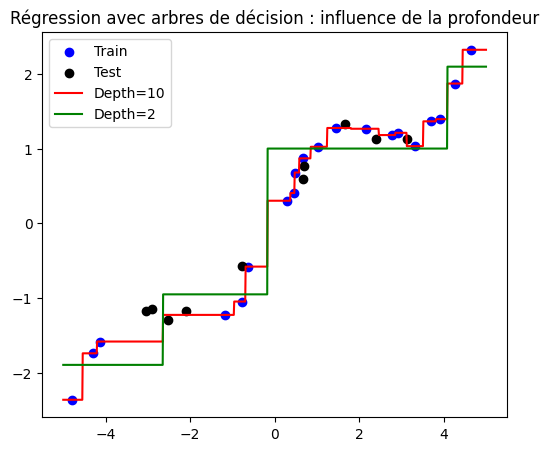

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn import tree


# Charger les données
data = np.load("../data/toy_data.npz")
x, y, xt, yt = data["x"], data["y"], data["xt"], data["yt"]

print(f"Train data shape: x={x.shape}, y={y.shape}")
print(f"Test data shape: xt={xt.shape}, yt={yt.shape}")

# Tracer les données d'entraînement et de test
plt.figure(figsize=(6,5))
plt.scatter(x, y, c='blue', label="Train")
plt.scatter(xt[::10], yt[::10], c='black', label="Test")  # Afficher seulement une partie des points test (1 sur 10)

# Comparer les modèles avec deux profondeurs
for max_depth, col in zip([10, 2], ['r', 'g']):
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(x, y)

    t = np.linspace(-5, 5, 1000).reshape(-1, 1)
    plt.plot(t, model.predict(t), col, label=f"Depth={max_depth}")

plt.legend()
plt.title("Régression avec arbres de décision : influence de la profondeur")
plt.show()


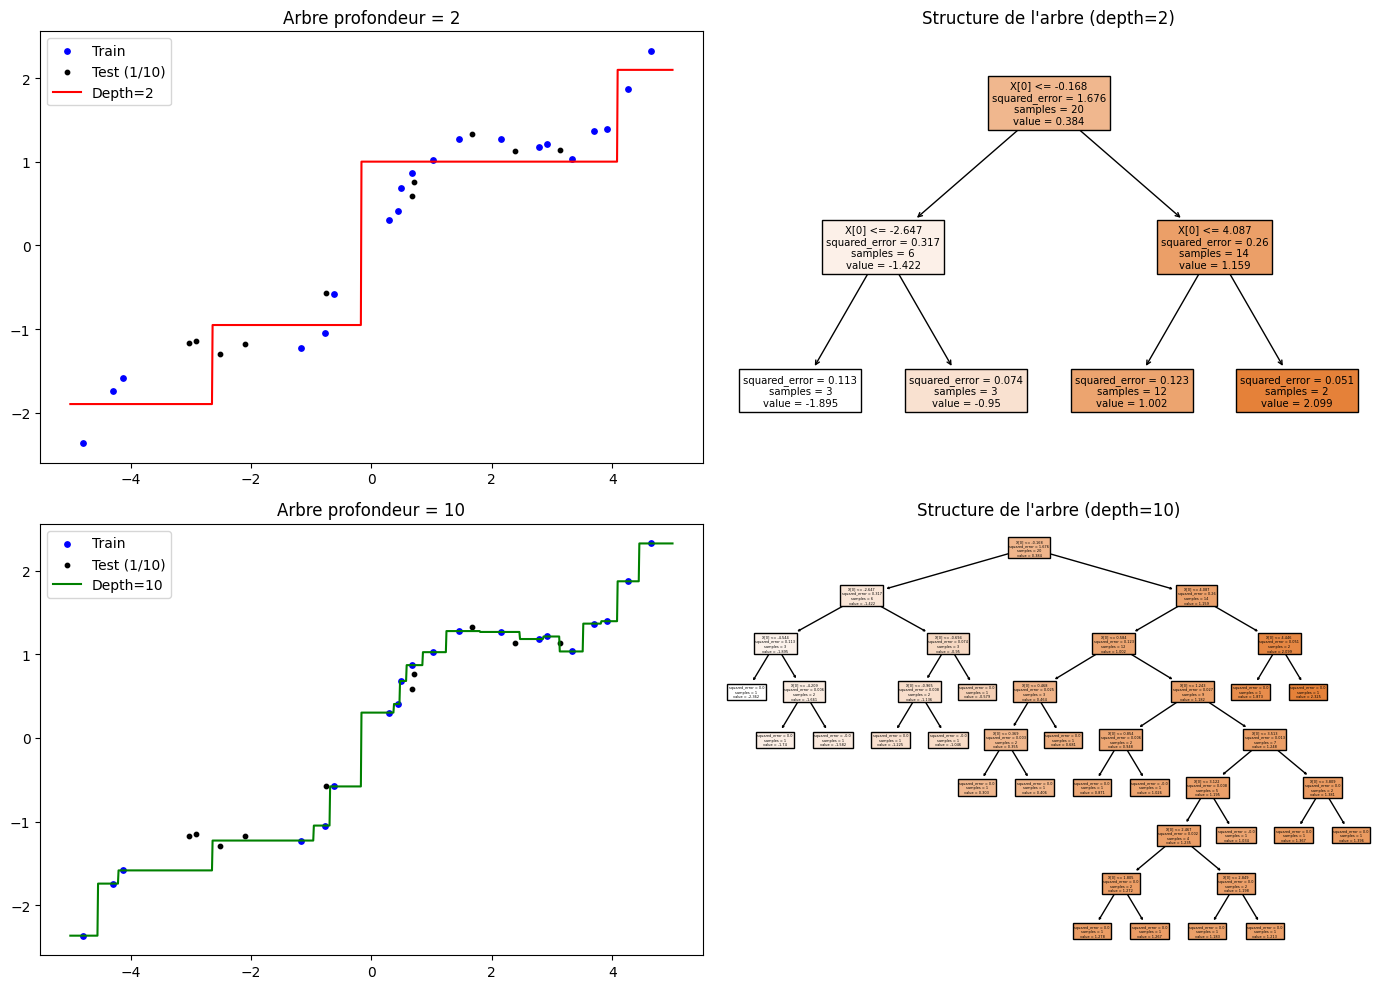

In [27]:
# Compare two depths
depths = [2, 10]
colors = ['r', 'g']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, (max_depth, col) in enumerate(zip(depths, colors)):

    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(x, y)

    # Gauche : visualisation de la prédiction
    ax_left = axes[i, 0]
    t = np.linspace(-5, 5, 1000).reshape(-1, 1)
    
    ax_left.scatter(x, y, c='b', s=15, label="Train")
    ax_left.scatter(xt[::10], yt[::10], c='k', s=10, label="Test (1/10)")
    ax_left.plot(t, model.predict(t), col, label=f"Depth={max_depth}")
    
    ax_left.set_title(f"Arbre profondeur = {max_depth}")
    ax_left.legend()

    # Droite : structure de l'arbre
    ax_right = axes[i, 1]
    tree.plot_tree(model, filled=True, ax=ax_right)
    ax_right.set_title(f"Structure de l'arbre (depth={max_depth})")

plt.tight_layout()
plt.show()

La profondeur maximale `max_depth` impose une borne supérieure à la complexité du modèle, mais la profondeur effective résulte du critère d’impureté : un nœud cesse d’être divisé lorsque le gain de pureté devient nul ou insuffisant. Ainsi, un arbre fixé à `max_depth = 10` n’atteint en pratique cette profondeur que si les données présentent une structure nécessitant 10 niveaux de partitionnement.

Lorsque la profondeur autorisée est grande, l’arbre produit des découpages très détaillés et s’adapte fortement aux données d’apprentissage. On observe alors un sur-apprentissage, visible dans la courbe de prédiction très irrégulière pour depth = 10. A l’inverse, un arbre peu profond (par exemple depth = 2) produit un modèle plus simple et plus facilement interprétable.

Ces limites des arbres de décision motivent l’usage des *Random Forest*, qui combinent de nombreux arbres pour obtenir des modèles plus robustes tout en évitant le sur-apprentissage d’un arbre unique.

#### 3.2 Forêts aléatoires (*Random Forest*)

Même si les arbres de décision sont des modèles simples et intuitifs, leur capacité d’apprentissage reste limitée. Lorsqu’ils sont trop profonds, ils s’adaptent fortement aux données d’entraînement et produisent un sur-apprentissage, tandis qu’un arbre peu profond reste plus interprétable mais moins précis. De plus, un arbre unique fournit une prédiction constante dans chaque région, ce qui limite sa finesse.

Pour dépasser ces limites, on utilise la méthode *Random Forest*, qui est une méthode d'ensemble et consiste à combiner un grand nombre d’arbres où chacun entraîné sur :

- un sous-échantillon des données (bootstrap),
- un sous-ensemble des variables testées à chaque nœud.
- 
Chaque arbre produit alors sa propre prédiction, et la forêt combine leurs résultats :

- moyenne des prédictions en régression,
- vote majoritaire en classification.

Cette approche permet d’obtenir un modèle beaucoup plus stable et performant qu’un arbre isolé, tout en étant peu sensible au réglage des hyperparamètres, à condition d’utiliser un nombre d’arbres suffisamment grand.
La contrepartie est que la lisibilité d’un arbre unique disparaît, mais *Random Forest* fournit tout de même un indicateur utile : l’importance des variables, mesurée selon leur contribution à l’amélioration du critère de pureté dans l’ensemble des arbres.


### Exemple en classification

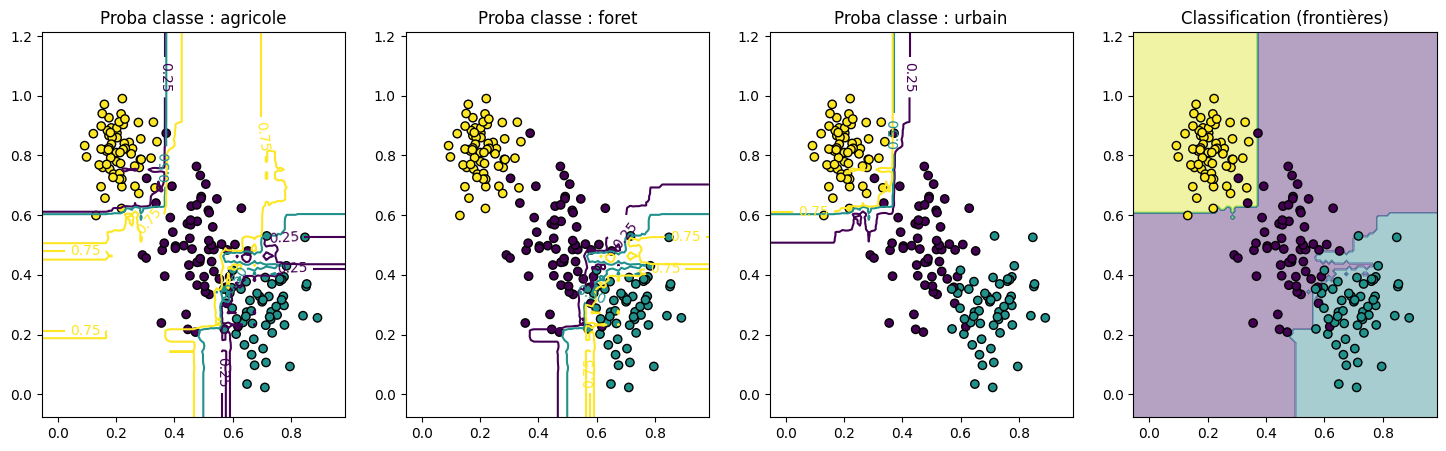

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split



# Charger un dataset depuis un CSV
df = pd.read_csv("./landcover_synthetic.csv")

# Encodage numérique des classes (softmax exige des entiers)
# Transforme la colonne 'label' en catégories et 
# attribue un numéro par classe (0, 1, 2...)
df["label_code"] = df["label"].astype("category").cat.codes

# On récupère la liste des noms de classes dans l'ordre des codes
class_names = df["label"].astype("category").cat.categories

# Extraction des variables explicatives (X) comme un tableau NumPy 2D
X = df[["NDVI", "Texture"]].values

# Extraction de la variable cible (y) comme un tableau NumPy 1D
y = df["label_code"].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, 
                                                    random_state=0)


# Model
model = RandomForestClassifier(n_estimators=200, max_depth=None)
model.fit(X_train, y_train)

# Limites du graphique (basées sur les données réelles)
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1  # NDVI avec une marge +/-0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1  # Texture avec une marge +/-0.1
h = 0.01 # pas de la grille plus petit = plus précis mais plus lent

# Création de la grille 2D
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# On transforme la grille en liste de points (NDVI, Texture)
grid = np.c_[xx.ravel(), yy.ravel()]

# Prédictions du modèle sur chaque point de la grille
Z_proba = model.predict_proba(grid)   # Probabilités par classe
Z_class = model.predict(grid)         # Classe finale prédite


# Affichage : probas (contours) + classification (zones colorées)
fig, axs = plt.subplots(1, 4, figsize=(18, 5))
C = len(class_names)

# Probabilité de chaque classe 
for c in range(C):
    # Contours de probabilité : où p = 0.25, 0.5, 0.75
    cs = axs[c].contour(xx, yy, 
                        Z_proba[:, c].reshape(xx.shape),
                        levels=[0.25, 0.5, 0.75])
    
    # Points de test superposés pour vérifier
    axs[c].scatter(X_test[:, 0],
                   X_test[:, 1],
                   c=y_test,
                   cmap='viridis', edgecolor='k')
    
    axs[c].clabel(cs, inline=1, fontsize=10)
    axs[c].set_title(f"Proba classe : {class_names[c]}")

# Prédiction finale
axs[-1].contourf(xx, yy, 
                 Z_class.reshape(xx.shape), 
                 alpha=0.4, cmap='viridis')
axs[-1].scatter(X_test[:, 0], X_test[:, 1], c=y_test,
                cmap='viridis', edgecolor='k')
axs[-1].set_title("Classification (frontières)")
plt.show()

#### Importance des variables 


,Variable,Importance
0,NDVI,0.562951
1,Texture,0.437049


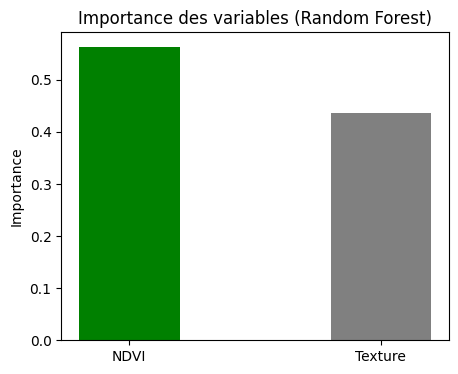

In [38]:
# Importance des variables
importances = model.feature_importances_
feature_names = ["NDVI", "Texture"]

# DataFrame pour affichage tabulaire
df_imp = pd.DataFrame({
    "Variable": feature_names,
    "Importance": importances
})
display(df_imp)

# Barplot des importances
plt.figure(figsize=(5, 4))
plt.bar(feature_names, importances, color=["green", "gray"], width=0.4)
plt.title("Importance des variables (Random Forest)")
plt.ylabel("Importance")
plt.show()

Le Random Forest attribue une importance à chaque variable en mesurant combien elle améliore le critère de pureté dans les arbres du modèle.  
Plus une variable est utilisée dans les splits « utiles », plus son importance est élevée.

#### Affichage de certains arbres du modèle

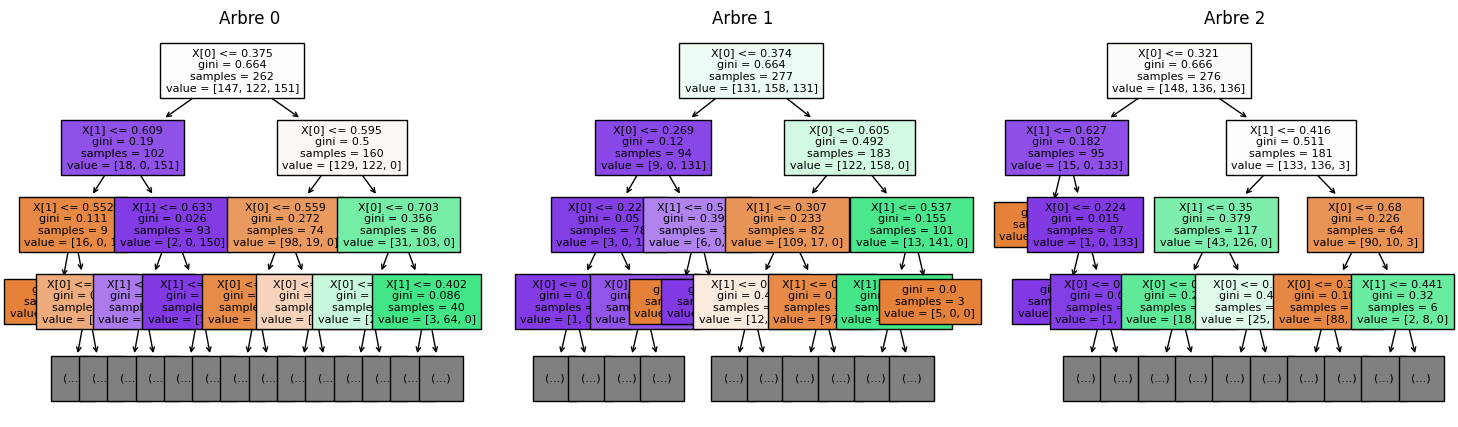

In [43]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, ax in enumerate(axs):
    tree.plot_tree(model.estimators_[i], max_depth=3, filled=True, ax=ax, fontsize=8)
    ax.set_title(f"Arbre {i}")